In [54]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import optuna
import statsmodels.api as sm
import plotly.graph_objects as go
import plotly.io as pio
import plotly.figure_factory as ff
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import root_mean_squared_error
from statsmodels.tools.tools import add_constant
import seaborn as sns
pio.renderers.default = 'iframe'

# Step 1: Load Data
----
Important Note: Do not forget to brew install brew install libomp if using mac or install libgomp-1.dll for windows to download pretrained model

In [4]:
data = pd.read_csv("datasets/orders.csv")
data

,order_id,order_timestamp,delivery_timestamp,distance_km,order_size,restaurant_popularity,weather_conditions,traffic_conditions
0,1,2024-08-01 12:00:00,2024-08-01 12:30:00,5.2,3,4.5,Clear,1
1,2,2024-08-01 12:05:00,2024-08-01 12:45:00,3.1,2,4.0,Rain,2
2,3,2024-08-01 12:10:00,2024-08-01 12:20:00,1.5,1,4.8,Clear,1
3,4,2024-08-01 12:15:00,2024-08-01 12:50:00,4.0,5,3.5,Cloudy,3
4,5,2024-08-01 12:20:00,2024-08-01 12:35:00,2.8,4,5.0,Clear,1
5,6,2024-08-01 12:25:00,2024-08-01 12:55:00,6.0,2,4.2,Rain,2
6,7,2024-08-01 12:30:00,2024-08-01 12:40:00,2.0,1,4.6,Clear,1
7,8,2024-08-01 12:35:00,2024-08-01 13:05:00,3.5,3,3.8,Fog,3
8,9,2024-08-01 12:40:00,2024-08-01 12:50:00,1.0,1,4.9,Clear,1
9,10,2024-08-01 12:45:00,2024-08-01 13:15:00,7.0,6,4.1,Rain,2


# Step 2: Check Data Types
---

In [5]:
data.dtypes

order_id                   int64
order_timestamp           object
delivery_timestamp        object
distance_km              float64
order_size                 int64
restaurant_popularity    float64
weather_conditions        object
traffic_conditions         int64
dtype: object

# Step 3: Change Data Type
---

In [6]:
data['order_id'] = data['order_id'] .astype(str)
data['order_timestamp'] = pd.to_datetime(data['order_timestamp'])
data['delivery_timestamp'] = pd.to_datetime(data['delivery_timestamp'])
data['time_to_deliver'] = data.delivery_timestamp - data.order_timestamp

# Step 4: Perform Feature Engineering
---
1. Create a new feature called "time to deliver", the amount of time between order to delivery.
2. Label Encode all categorical data.

In [7]:
data2 = data.copy()
# Convert 'time_to_deliver' to minutes
data2['time_to_deliver'] = pd.to_timedelta(data2['time_to_deliver']).dt.total_seconds() / 60
# Encode categorical variables
label_encoder = LabelEncoder()
data2['weather_conditions'] = label_encoder.fit_transform(data2['weather_conditions'])

In [8]:
data2

,order_id,order_timestamp,delivery_timestamp,distance_km,order_size,restaurant_popularity,weather_conditions,traffic_conditions,time_to_deliver
0,1,2024-08-01 12:00:00,2024-08-01 12:30:00,5.2,3,4.5,0,1,30.0
1,2,2024-08-01 12:05:00,2024-08-01 12:45:00,3.1,2,4.0,3,2,40.0
2,3,2024-08-01 12:10:00,2024-08-01 12:20:00,1.5,1,4.8,0,1,10.0
3,4,2024-08-01 12:15:00,2024-08-01 12:50:00,4.0,5,3.5,1,3,35.0
4,5,2024-08-01 12:20:00,2024-08-01 12:35:00,2.8,4,5.0,0,1,15.0
5,6,2024-08-01 12:25:00,2024-08-01 12:55:00,6.0,2,4.2,3,2,30.0
6,7,2024-08-01 12:30:00,2024-08-01 12:40:00,2.0,1,4.6,0,1,10.0
7,8,2024-08-01 12:35:00,2024-08-01 13:05:00,3.5,3,3.8,2,3,30.0
8,9,2024-08-01 12:40:00,2024-08-01 12:50:00,1.0,1,4.9,0,1,10.0
9,10,2024-08-01 12:45:00,2024-08-01 13:15:00,7.0,6,4.1,3,2,30.0


 # Step 5: Perform Exploratory Data Analysis
---
- Distribution Analysis:
    1. How frequent do we get orders?
    2. How Fast is our delivery time?
    3. How far is our customers from their preferred restuarant?
    4. How much do our customer order?
    5. Where do mostly of the customer buy from?
    
- Relationship analysis:
    6. What is the relationship between Weather Condition, traffic condition and order size?
    7. What is the relationship between Weather Condition, traffic condition and delivery time?

##### Note: We will not perform correlation analysis at this part as this will be done during the modeling part.

#### 1. How frequent do we get orders?
---
- There is no need to graph since it is obvious that we get new orders every 5 minutes

In [9]:
pd.to_timedelta(data2.order_timestamp.diff())

0               NaT
1   0 days 00:05:00
2   0 days 00:05:00
3   0 days 00:05:00
4   0 days 00:05:00
5   0 days 00:05:00
6   0 days 00:05:00
7   0 days 00:05:00
8   0 days 00:05:00
9   0 days 00:05:00
Name: order_timestamp, dtype: timedelta64[ns]

#### 2. How Fast is our delivery time?
---
Most of out drivers travel at 30 minutes to deliver an order.

In [10]:
group_labels = ['Delivery']
fig = ff.create_distplot([data2.time_to_deliver], group_labels)
fig.show()

#### 3. How far is our customers from their preferred restuarant?
---
Most of our customers are within the 3 kilometer radius from their preferred restaurant.

In [11]:
group_labels = ['Distance']
fig = ff.create_distplot([data2.distance_km], group_labels)
fig.show()

#### 4. How much do our customer order?
---
- Our customers usually has an order size of between 2 to 3 products.

In [12]:
group_labels = ['Size']
fig = ff.create_distplot([data2.order_size], group_labels)
fig.show()

#### 6. What is the relationship between Weather Condition, traffic condition and order size?
---
- Most orders are done during a cloudy day, and less orders are done on a clear day. This is obvious since people tend to buy on a fair weather, and drivers tend not to accept orders during rainy weathers.
- Interestingy, orders are high during a cloudy weather and high traffic.

In [13]:
rel1 = data[["order_size","weather_conditions","traffic_conditions"]]
rel1["ave_order_size"] = rel1.groupby(["weather_conditions","traffic_conditions"])["order_size"].transform("mean")
rel1 = rel1.drop("order_size", axis=1)

In [14]:
fig = go.Figure(data=go.Heatmap(
                   z=rel1.ave_order_size,
                   x=rel1.traffic_conditions,
                   y=rel1.weather_conditions,
                   hoverongaps = False))
fig.show()

#### 7. What is the relationship between Weather Condition, traffic condition and delivery time?
---
- Orders are delayed mostly during a cloudy weather, followed by during rain, lastly during a foggy weather. This might be because people tend to panic to travel home during a cloudy weather to avoid the rain.

In [15]:
rel2_1 = data[["order_id","weather_conditions","traffic_conditions"]]
rel2_2 = data2[["order_id","traffic_conditions","time_to_deliver"]]
rel2 = pd.merge(rel2_1,rel2_2, how = "right", on = ["order_id","traffic_conditions"])
rel2["ave_time_to_deliver"] = rel2.groupby(["weather_conditions","traffic_conditions"])["time_to_deliver"].transform("mean")
rel2 = rel2.drop("time_to_deliver", axis=1)

In [16]:
fig = go.Figure(data=go.Heatmap(
                   z=rel2.ave_time_to_deliver,
                   x=rel2.traffic_conditions,
                   y=rel2.weather_conditions,
                   hoverongaps = False))
fig.show()

# Baseline Model: Linear Regression
---
For the baseline model the standard method is linear regression due to its simplicity, ease of interpretation, and ease of implementation.

In [17]:
df_reg = data2.drop(["order_id","order_timestamp","delivery_timestamp"], axis=1)
df_reg

,distance_km,order_size,restaurant_popularity,weather_conditions,traffic_conditions,time_to_deliver
0,5.2,3,4.5,0,1,30.0
1,3.1,2,4.0,3,2,40.0
2,1.5,1,4.8,0,1,10.0
3,4.0,5,3.5,1,3,35.0
4,2.8,4,5.0,0,1,15.0
5,6.0,2,4.2,3,2,30.0
6,2.0,1,4.6,0,1,10.0
7,3.5,3,3.8,2,3,30.0
8,1.0,1,4.9,0,1,10.0
9,7.0,6,4.1,3,2,30.0


### 1. Correlation Analysis
---
"Not all models are created equal"

For linear models it is necessary to remove highly correlated variables due to the following reasons:

1. Unstable Estimates of Coefficients:

    - When predictor variables are highly correlated, it becomes difficult for the linear model to determine the individual effect of each predictor on the response variable. This leads to unstable estimates of the regression coefficients, which can vary widely with small changes in the data.

2. Inflated Standard Errors:

    - Multicollinearity increases the standard errors of the estimated coefficients, making the model less reliable. This means that even if a variable is actually relevant, the model might fail to identify it as statistically significant due to the inflated standard error.


3. Difficulty in Interpreting Coefficients:

     - In a linear model, coefficients represent the change in the response variable for a one-unit change in the predictor, holding all other variables constant. When variables are highly correlated, this interpretation becomes meaningless because it’s not possible to change one predictor without changing the other.

4. Reduced Predictive Power:

    - Although multicollinearity does not always impact the predictive ability of the model on the training data, it can negatively affect the model's generalization to new data. This is because the model relies on relationships that may not hold outside the training dataset.
    
Correlation coefficients between 0.7 to 1.0 are considered highly correlated

#### Analysis
---
- Weather conditions and traffic are strongly correlated to the dependent variable, time to deliver. This indicates that these two variables have a strong linear relationship with the delivery time and are might therefore good predictors.

- Restaurant popularity is strongly, but negatively, correlated with traffic conditions, indicating that these two predictors convey the same information. For this experiment, restaurant popularity will be removed.

In [18]:
# calculate the correlation matrix on the numeric columns
corr = df_reg.select_dtypes('number').corr()

cmap = sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .format(precision=3)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Correlation Coefficient")\
    .set_table_styles(magnify())

,distance_km,order_size,restaurant_popularity,weather_conditions,traffic_conditions,time_to_deliver
distance_km,1.000,0.676,-0.496,0.647,0.401,0.668
order_size,0.676,1.000,-0.485,0.336,0.493,0.513
restaurant_popularity,-0.496,-0.485,1.000,-0.649,-0.941,-0.834
weather_conditions,0.647,0.336,-0.649,1.000,0.637,0.739
traffic_conditions,0.401,0.493,-0.941,0.637,1.000,0.728
time_to_deliver,0.668,0.513,-0.834,0.739,0.728,1.000


In [62]:
# Separate features and target variable
X_reg1 = df_reg.drop(columns=['time_to_deliver','restaurant_popularity'])
y_reg1 = df_reg['time_to_deliver']
# Split the data
X_train_reg1, X_test_reg1, y_train_reg1, y_test_reg1 = train_test_split(X_reg1, y_reg1, test_size=0.2, random_state=42)

In [63]:
# Define the dependent and independent variables
X = X_reg1[['distance_km','weather_conditions', 'traffic_conditions']]
y = y_reg1

# Add a constant term for the intercept
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()
# print('Model RMSE: ', root_mean_squared_error(y_reg2, model.predict(X_reg2)))
print("\nFinal model summary:")
print(model.summary())


Final model summary:
                            OLS Regression Results                            
Dep. Variable:        time_to_deliver   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     5.205
Date:                Sat, 27 Sep 2025   Prob (F-statistic):             0.0416
Time:                        11:47:59   Log-Likelihood:                -31.677
No. Observations:                  10   AIC:                             71.35
Df Residuals:                       6   BIC:                             72.56
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const         

### 2. Feature Selection: Bacward Elimination
---
- The linear model starts with the entire variables and individually remove each variables based on a level of significance. In this experiment the order size does not significantly contribute to the prediction model.
- distance, weather condition, and traffic condition have statistically signicant levels indicating that these are good predictors of the outcome.
- This experiment validates the correlation analysis above, as can be seen that the order size is only mildly correlated to the outcome with a value of 0.513.
- The regression line is almost perfectly linear with an adjusted $R^2$ of 0.944.
- However, the number of sample is not enough to check for the impact of kurtosis (the shape of the data distribution), since linear regression models are heavily dependent on the normality assumption.

In [92]:
# Backward elimination function
def backward_elimination(X, y, significance_level=0.05):
    features = list(X.columns)
    while len(features) > 0:
        X_with_constant = add_constant(X[features])
        model = sm.OLS(y, X_with_constant).fit()
        pvalues = model.pvalues.iloc[1:]  # Skip the intercept's p-value
        max_pval = pvalues.max()

        if max_pval > significance_level:
            # Remove the feature with the highest p-value
            worst_feature = pvalues.idxmax()
            features.remove(worst_feature)
            print(f"Removed feature: {worst_feature}, p-value: {max_pval}")
        else:
            break

    # Fit the final model with remaining features
    final_model = sm.OLS(y, add_constant(X[features])).fit()
    return final_model, features

# Run backward elimination on the training data
final_model, selected_features = backward_elimination(X_train_reg1, y_train_reg1)

# Print the summary of the final model
print("\nFinal model summary:")
print(final_model.summary())

# Print the remaining features after backward elimination
print("\nSelected features after backward elimination:")
print(selected_features)

Removed feature: order_size, p-value: 0.13250797065731543

Final model summary:
                            OLS Regression Results                            
Dep. Variable:        time_to_deliver   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     40.47
Date:                Sat, 27 Sep 2025   Prob (F-statistic):            0.00189
Time:                        12:06:38   Log-Likelihood:                -15.666
No. Observations:                   8   AIC:                             39.33
Df Residuals:                       4   BIC:                             39.65
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

### 3. K-Fold Validation
---
- To create a more robust overview of the model given the different variability of the data a k-fold corss validation is conducted, root mean squared error is used as the performance metric.

In [93]:
# Separate features and target variable
X = df_reg[['distance_km','weather_conditions', 'traffic_conditions']]
y = df_reg['time_to_deliver']

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store the MSE values for each fold
rmse_values = []

# Perform the K-Fold Cross-Validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model on the training set
    model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
    
    # Make predictions on the test set
    y_pred = model.predict(sm.add_constant(X_test))
    
    # Calculate the mean squared error
    rmse = root_mean_squared_error(y_test, y_pred)
    rmse_values.append(rmse)

# Output the mean MSE over the folds
print(f"Mean RMSE: {np.mean(rmse_values)} minutes")

Mean RMSE: 10.855879544964612 minutes


# Proposed Model: XGBOOST
---

#### Why XGBOOST?
---
- XGBoost (Extreme Gradient Boosting) is an advanced implementation of the gradient boosting algorithm, which is designed for speed and performance. It builds an ensemble of decision trees in a sequential manner to improve predictive accuracy, and each tree tries to correct the errors of the previous ones. Key features of XGBoost include:

- Regularization: It uses both L1 (Lasso) and L2 (Ridge) regularization to prevent overfitting, making it robust to noisy data.

- Tree Pruning: XGBoost employs a technique called "max depth" pruning, where it starts with a full tree and prunes unnecessary branches.

- Handling Missing Values: It can natively handle missing values in the dataset by learning which path to take based on the observed values.

- Parallelization: The algorithm supports parallel computation, making it faster than other boosting methods.

- Custom Loss Functions: XGBoost allows for user-defined objective functions for specific use cases.


#### Insensitivity to Correlated Variables
---
- XGBoost, like other tree-based algorithms, is generally less sensitive to multicollinearity (correlated variables) compared to linear models. The decision tree structure allows it to handle correlated features without significantly degrading performance.

In [94]:
# Separate features and target variable
df = df_reg.copy()
X = df.drop(columns=['time_to_deliver'])
y = df['time_to_deliver']
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [95]:
X_train.columns

Index(['distance_km', 'order_size', 'restaurant_popularity',
       'weather_conditions', 'traffic_conditions'],
      dtype='object')

### Step 1: Fine tuning the model
---
- XGBoost tend to have multiple parameters to tune, to find the optimal parameters Parzan Tree is used, with RMSE as the performance metric.

In [102]:
def objective(trial):
    # Define the hyperparameters to tune
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0)
    }

    # Train the XGBoost model
    model = xgb.XGBRegressor(**param)
    model.fit(X_train, y_train)

    # Predict on the validation set
    y_pred = model.predict(X_test)

    # Calculate the RMSE
    rmse = root_mean_squared_error(y_test, y_pred)

    return rmse

In [107]:
# Create a study to minimize the RMSE
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)  # You can increase n_trials for a more exhaustive search

# Print the best hyperparameters
print("Best Hyperparameters:", study.best_params)

[I 2025-09-27 12:10:02,653] A new study created in memory with name: no-name-b1dbe0be-6fcc-408c-9ba8-124644faf1c8
/var/folders/jd/rmzvvh4s2jzg55h334m9_q040000gn/T/ipykernel_73630/1744136363.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-09-27 12:10:02,779] Trial 0 finished with value: 13.085301135714149 and parameters: {'n_estimators': 437, 'max_depth': 5, 'learning_rate': 0.19029770010799685, 'subsample': 0.5881794612252329, 'colsample_bytree': 0.7196417203785759, 'gamma': 1.0115715569781663, 'lambda': 6.045954744486665, 'alpha': 9.211397162988545}. Best is trial 0 with value: 13.085301135714149.
/var/folders/jd/rmzvvh4s2jzg55h334m9_q040000gn/T/ipykernel_73630/1744136363.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/opt

Best Hyperparameters: {'n_estimators': 285, 'max_depth': 7, 'learning_rate': 0.021354477159285488, 'subsample': 0.6432831830450241, 'colsample_bytree': 0.5447486697611413, 'gamma': 4.487033179783025, 'lambda': 5.750418647105777, 'alpha': 2.4340031467687604}


### Step 2: Use the optimal parameters to train the XGBoost model
---
- Check the optimal RMSE after training.

In [106]:
# Use the best hyperparameters to train the final model
best_params = study.best_params
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

# Evaluate on the test set
y_pred = best_model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print(f'Optimized RMSE: {rmse:.2f} minutes')

Optimized RMSE: 10.30 minutes


### Step 3: Checking for Feature Importance
---

1. What is Gain in XGBoost?
Gain measures the improvement in the model's objective function (e.g., error reduction or information gain) when a feature is used to split the data at a node in the decision tree. It represents how much a feature contributes to reducing the prediction error. XGBoost builds trees iteratively, and at each step, it looks for the best split to reduce the objective function. The "gain" is used to evaluate which feature should be split at each point in the tree.

2. How is Gain Calculated?

- Objective Function: In XGBoost, the objective function consists of a loss function (such as squared error for regression or log-loss for classification) and a regularization term to prevent overfitting.

- Gain Calculation: Gain is calculated based on the difference between the loss function before and after splitting on a particular feature. At each possible split point, XGBoost evaluates how the split affects the error. It checks the error reduction achieved by splitting the data into two sub-groups and sums the errors for both groups.

For a feature, $f$, gain is calculated as:

\begin{align}
\text{Information Score} = Score_{\text{left child}} + Score_{\text{right child}} − Score_{\text{Parent}}
\end{align}
 
where:

    - Score represents the contribution of a node to the overall model performance, based on the loss function.
    - The left child and right child refer to the two nodes created after the split.

- The goal is to maximize this gain at each node when building the decision tree.

- Feature Importance: Once the decision trees are built, the importance of a feature is derived by summing up the gain for all splits that use that feature across all trees in the model. Features with higher cumulative gains are considered more important since they contribute more to reducing the prediction error.

3 . Why Use Gain for Feature Importance?

- Interpretability: Gain provides a direct measure of how useful a feature is for improving model accuracy. A higher gain indicates that a feature plays a more significant role in model performance.

- Ranking Features: It allows us to rank features based on their contribution to the model, which is valuable for understanding which features are most influential in making predictions.

4. Limitations:

- Bias towards features with many possible values: Gain might give more importance to features with a high number of potential split points, like continuous variables, which can sometimes result in overestimating their importance.

#### Interpreation
---

- The result showed that only distance and restaurant popularity has an impact on the XGBOOST regresstion model.

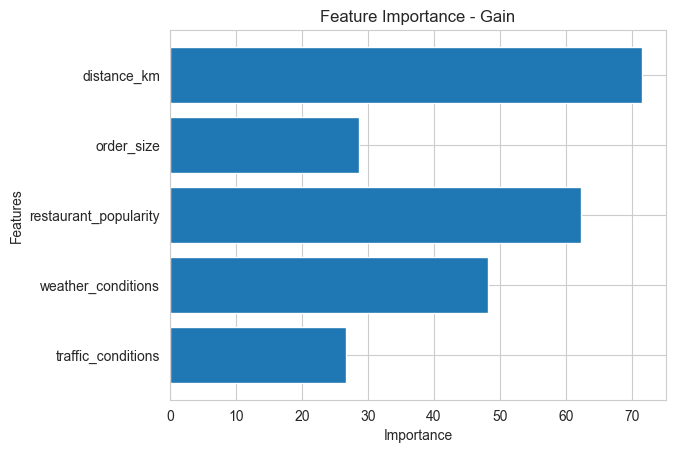

In [109]:
# Plot feature importance
# Convert feature importance to a DataFrame
importance = best_model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])

# Plot using matplotlib
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance - Gain')
plt.gca().invert_yaxis() # To display the most important feature at the top
plt.show()

### Step 4: Retraining the model with the important features

In [110]:
df2 = df.drop(['order_size','weather_conditions', 'traffic_conditions'], axis=1)

In [111]:
# Separate features and target variable
X2 = df2.drop(columns=['time_to_deliver'])
y2 = df2['time_to_deliver']
# Split the data
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [112]:
X_train2.columns

Index(['distance_km', 'restaurant_popularity'], dtype='object')

In [113]:
def objective2(trial):
    # Define the hyperparameters to tune
    param = {
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0)
    }

    # Train the XGBoost model
    model = xgb.XGBRegressor(**param)
    model.fit(X_train2, y_train2)

    # Predict on the validation set
    y_pred2 = model.predict(X_test2)

    # Calculate the RMSE
    rmse = root_mean_squared_error(y_test2, y_pred2)

    return rmse

In [114]:
# Create a study to minimize the RMSE
study2 = optuna.create_study(direction='minimize')
study2.optimize(objective2, n_trials=50)  # You can increase n_trials for a more exhaustive search

# Print the best hyperparameters
print("Best Hyperparameters:", study2.best_params)

[I 2025-09-27 12:14:51,638] A new study created in memory with name: no-name-fb4bc932-dac9-4186-ae42-e9f5e120a8e4
/var/folders/jd/rmzvvh4s2jzg55h334m9_q040000gn/T/ipykernel_73630/2934146010.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-09-27 12:14:51,723] Trial 0 finished with value: 11.291512204172413 and parameters: {'n_estimators': 247, 'max_depth': 5, 'learning_rate': 0.04655004989318156, 'subsample': 0.6521617439323978, 'colsample_bytree': 0.6953424103160303, 'gamma': 2.7857487365290794, 'lambda': 2.9144660080237306, 'alpha': 3.061282563703025}. Best is trial 0 with value: 11.291512204172413.
/var/folders/jd/rmzvvh4s2jzg55h334m9_q040000gn/T/ipykernel_73630/2934146010.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/op

Best Hyperparameters: {'n_estimators': 175, 'max_depth': 3, 'learning_rate': 0.2384367710292283, 'subsample': 0.5366537008012845, 'colsample_bytree': 0.6385422184092278, 'gamma': 2.93904031637385, 'lambda': 0.669078268418586, 'alpha': 1.0014664442504753}
Best RMSE: 9.217884565541961


In [115]:
# Use the best hyperparameters to train the final model
best_params2 = study2.best_params
best_model2 = xgb.XGBRegressor(**best_params2)
best_model2.fit(X_train2, y_train2)

# Evaluate on the test set
y_pred2 = best_model2.predict(X_test2)
rmse = root_mean_squared_error(y_test2, y_pred2)
print(f'Optimized RMSE: {rmse:.2f} minutes')

Optimized RMSE: 9.22 minutes


### Step 5: Performing K-Fold Validation
---

In [116]:
# Perform 5-fold cross-validation
k = 5
scores = cross_val_score(best_model, X, y, cv=k, scoring='neg_root_mean_squared_error')

# Convert scores to positive and print the average RMSE
rmse_scores = -scores
print(f'RMSE scores for each fold: {rmse_scores}')
print(f'Average RMSE: {np.mean(rmse_scores):.2f} minutes')

RMSE scores for each fold: [10.91593596  4.88154953  4.48438975  7.9187555   3.81695696]
Average RMSE: 6.40 minutes


# Recommendations
---

1. Prepare more on-call drivers during cloudy weather.
2. Have more call agents during cloudy weather to recieve complaints.
3. Since app usage is high during cloudy weather, provide higher storing and computing capacity during this season.
4. More data to achieve a more accurate model.

# Conclusion